In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import ndes.nde as nde
import distributions.priors as priors
import getdist
from getdist import plots, MCSamples

%matplotlib inline

Using Theano backend.


In [2]:
# Set up and load in data and simulations

# Fiducial parameters about which data compression is performed
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])


# Set up the truncated Gaussian prior...

# Prior boundaries
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])

# Prior mean and covariance
prior_mean = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
Q = np.eye(5)*np.array([0.1, 0.1, 0.05, 0.3, 0.3])**2

# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)


# Parameter names and ranges for plotting...  
names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
labels =  ['\\Omega_m', 'S_8', '\\Omega_b', 'h', 'n_s']
ranges = {'\Omega_m':[lower[0], upper[0]], 'S_8':[lower[1],upper[1]],'\Omega_b':[lower[2],upper[2]],
            'h':[lower[3],upper[3]],'n_s':[lower[4],upper[4]]}


# Import data summaries, simulated data summaries and corresponding parameters, and inverse Fisher matrix...
data = np.genfromtxt('simulators/cosmic_shear_pre-ran_sims/compressed_data.dat')
sim_params = np.genfromtxt('simulators/cosmic_shear_pre-ran_sims/simulations_parameters.dat')
sim_data = np.genfromtxt('simulators/cosmic_shear_pre-ran_sims/simulations_compressed_data.dat')
Finv = np.genfromtxt('simulators/cosmic_shear_pre-ran_sims/Finv.dat')

In [3]:
# Create the DELFI MDN object
n_components = 3

mdn = nde.DelfiMixtureDensityNetwork(data, prior, [lower, upper], Finv, theta_fiducial, n_components, n_hidden = [50, 50], activations = ['tanh', 'tanh'], names = names, labels = labels, ranges = ranges)

In [4]:
# Load in the simulations
mdn.load_simulations(sim_data, sim_params)

Generating pre-training data...
Training on the pre-training data...
Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 62s 1ms/step - loss: 18.8718 - val_loss: 12.5924
Epoch 2/100
45000/45000 [==============================] - 64s 1ms/step - loss: 11.5567 - val_loss: 10.6227
Epoch 3/100
45000/45000 [==============================] - 64s 1ms/step - loss: 10.0195 - val_loss: 9.4110
Epoch 4/100
45000/45000 [==============================] - 71s 2ms/step - loss: 9.0938 - val_loss: 8.7036
Epoch 5/100
45000/45000 [==============================] - 73s 2ms/step - loss: 8.5584 - val_loss: 8.2446
Epoch 6/100
45000/45000 [==============================] - 62s 1ms/step - loss: 8.1050 - val_loss: 7.9287
Epoch 7/100
45000/45000 [==============================] - 61s 1ms/step - loss: 7.7911 - val_loss: 7.6790
Epoch 8/100
45000/45000 [==============================] - 60s 1ms/step - loss: 7.5551 - val_loss: 7.2926
Epoch 9/100
45000/45000 [====

45000/45000 [==============================] - 59s 1ms/step - loss: 4.0502 - val_loss: 4.0284
Epoch 77/100
45000/45000 [==============================] - 60s 1ms/step - loss: 4.0514 - val_loss: 4.0062
Epoch 78/100
45000/45000 [==============================] - 60s 1ms/step - loss: 4.0120 - val_loss: 4.1083
Epoch 79/100
45000/45000 [==============================] - 60s 1ms/step - loss: 4.0279 - val_loss: 3.8871
Epoch 80/100
45000/45000 [==============================] - 59s 1ms/step - loss: 4.0416 - val_loss: 3.8362
Epoch 81/100
45000/45000 [==============================] - 59s 1ms/step - loss: 3.9991 - val_loss: 3.8683
Epoch 82/100
45000/45000 [==============================] - 59s 1ms/step - loss: 4.0293 - val_loss: 4.0655
Epoch 83/100
45000/45000 [==============================] - 59s 1ms/step - loss: 4.0018 - val_loss: 4.1285
Epoch 84/100
45000/45000 [==============================] - 60s 1ms/step - loss: 4.0092 - val_loss: 3.9684
Epoch 85/100
45000/45000 [========================

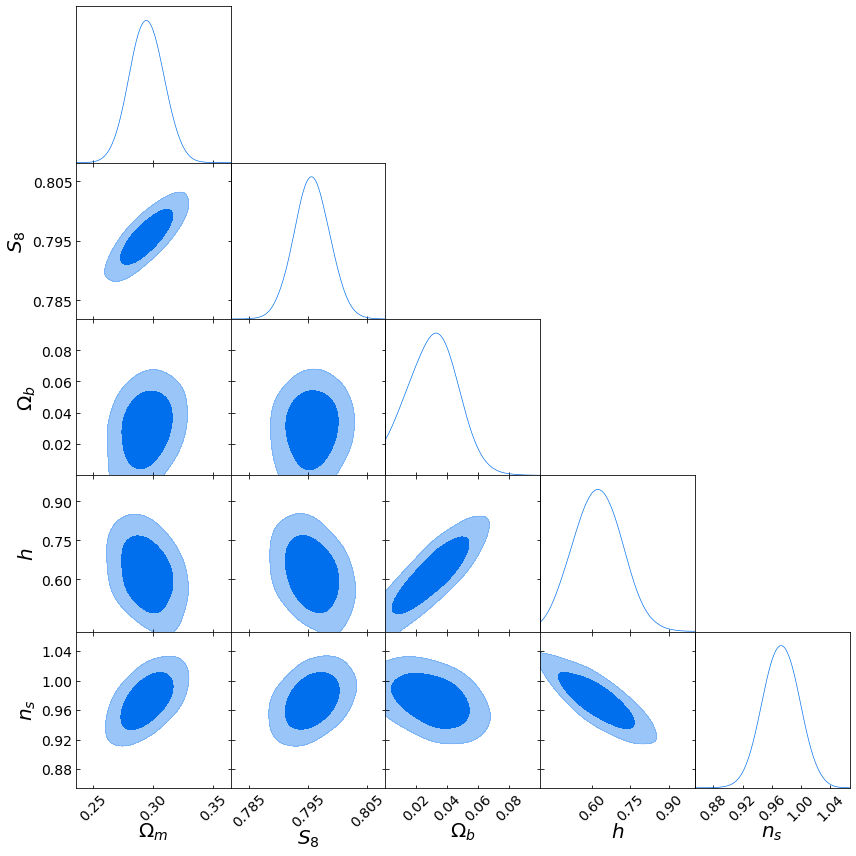

In [5]:
# Do the Fisher pre-training to inirialize the network (NB this may take some time, be patient :) )
mdn.fisher_pretraining(50000, prior, epochs=100)

In [ ]:
# Train the network
mdn.train(epochs=500, patience=20)

Train on 10800 samples, validate on 1200 samples
Epoch 1/500
10800/10800 [==============================] - 16s 1ms/step - loss: 4.4119 - val_loss: 4.4730
Epoch 2/500
10800/10800 [==============================] - 16s 1ms/step - loss: 4.3756 - val_loss: 4.5416
Epoch 3/500
10800/10800 [==============================] - 14s 1ms/step - loss: 4.3985 - val_loss: 4.4325
Epoch 4/500
10800/10800 [==============================] - 14s 1ms/step - loss: 4.4650 - val_loss: 4.5003
Epoch 5/500
10800/10800 [==============================] - 15s 1ms/step - loss: 4.4161 - val_loss: 4.5276
Epoch 6/500
10800/10800 [==============================] - 22s 2ms/step - loss: 4.3963 - val_loss: 4.4065
Epoch 7/500
10800/10800 [==============================] - 16s 2ms/step - loss: 4.3953 - val_loss: 4.4236
Epoch 8/500
10800/10800 [==============================] - 14s 1ms/step - loss: 4.3980 - val_loss: 4.2954
Epoch 9/500
10800/10800 [==============================] - 15s 1ms/step - loss: 4.3697 - val_loss: 4.48

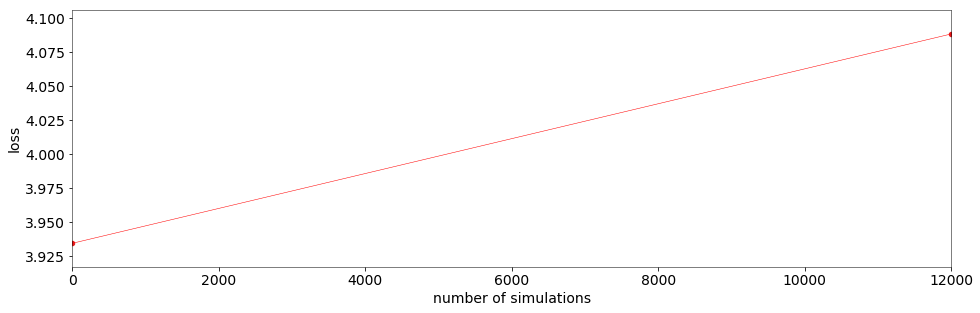

In [11]:
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()

In [7]:
# Triangle plot

plt.close()
columnwidth = 40 # cm
aspect = 1.67*2
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black',
                 'axes.color_cycle': ['#E41A1C', '#377EB8', '#4DAF4A', '#FF7F00']})


g = plots.getSubplotPlotter(width_inch = 12)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.6
g.settings.axes_fontsize=14
g.settings.legend_fontsize=16
g.settings.lab_fontsize=20
mc_samples = MCSamples(mdn.posterior_samples, names = names, labels = labels, ranges = ranges)

g.triangle_plot(mc_samples, normalized=True)

for i in range(0, len(samples[0][0,:])):
    for j in range(0, i+1):
        ax = g.subplots[i,j]
        xtl = ax.get_xticklabels()
        ax.set_xticklabels(xtl, rotation=45)
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()